In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import PIL.Image
import tensorflow as tf
import urllib.request
import os
import zipfile
import imageio
from skimage import transform

In [3]:
#Step 1 - download google's pre-trained neural network
url = 'https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip'
data_dir = 'data/'
model_name = os.path.split(url)[-1]
local_zip_file = os.path.join(data_dir, model_name)
if not os.path.exists(local_zip_file):
    # Download
    model_url = urllib.request.urlopen(url)
    with open(local_zip_file, 'wb') as output:
        output.write(model_url.read())
    # Extract
    with zipfile.ZipFile(local_zip_file, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

In [4]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

model_fn = 'tensorflow_inception_graph.pb'

#Step 2 - Creating Tensorflow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph,config=tf.ConfigProto(log_device_placement=True))
with tf.gfile.FastGFile(os.path.join(data_dir, model_fn), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

Number of layers 59
Total number of feature channels: 7548


In [5]:
#####HELPER FUNCTIONS. I didn't go over these in the video for times sake. They are mostly just formatting functions. Scroll 
#to the bottom #########################################################################################################
########################################################################################################################
############################################################

# Helper functions for TF Graph visualization
#pylint: disable=unused-variable
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() #pylint: disable=maybe-no-member
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() #pylint: disable=maybe-no-member
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

def showarray(a):
    a = np.uint8(np.clip(a, 0, 1)*255)
    plt.imshow(a)
    plt.show()

def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    img = img0.copy()
    for _ in range(iter_n):
        g, _ = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
    showarray(visstd(img))

def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)    

In [6]:
#BACK TO CODE IN THE VIDEO###########################################################################################
########################################################################################################
##############################################################################

#CHALLENGE - Write a function that outputs a deep dream video
def render_deepdreamvideo(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for _ in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for _ in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            
    return img


def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for _ in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for _ in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))

        #this will usually be like 3 or 4 octaves
        #Step 5 output deep dream image via matplotlib
        showarray(img/255.0)

In [ ]:
filename = 'data/vid2.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')

In [ ]:
writer = imageio.get_writer('data/test.mp4', fps=int(vid._meta['fps']//3))

for num, image in enumerate(vid.iter_data()):
    if num % 3 == 0:
        continue
    layer = 'mixed4d_3x3_bottleneck_pre_relu'
    channel = 55

    #open image
    img0 = image
    #img0 = transform.resize(img0, (224, 224), anti_aliasing=True,mode='reflect')
    img0 = np.float32(np.uint8(img0*-255))

    #Step 4 - Apply gradient ascent to that layer
    n_img = render_deepdreamvideo(tf.square(T(layer)[:,:,:,channel]), img0,iter_n=10)
    #showarray(n_img/255.0)
    writer.append_data(np.uint8(np.clip(n_img,0,255)))

    timestamp = float(num)/ vid.get_meta_data()['fps']
    print(timestamp)
            
writer.close()

0.06666666666666667
0.13333333333333333
0.26666666666666666
0.3333333333333333
0.4666666666666667
0.5333333333333333
0.6666666666666666
0.7333333333333333
0.8666666666666667
0.9333333333333333
1.0666666666666667
1.1333333333333333
1.2666666666666666
1.3333333333333333
1.4666666666666666
1.5333333333333334
1.6666666666666667
1.7333333333333334
1.8666666666666667
1.9333333333333333
2.066666666666667
2.1333333333333333
2.2666666666666666
2.3333333333333335
2.466666666666667
2.533333333333333
2.6666666666666665
2.7333333333333334
2.8666666666666667
2.933333333333333
3.066666666666667
3.1333333333333333
3.2666666666666666
3.3333333333333335
3.466666666666667
3.533333333333333
3.6666666666666665
3.7333333333333334
3.8666666666666667
3.933333333333333
4.066666666666666
4.133333333333334
4.266666666666667
4.333333333333333
4.466666666666667
4.533333333333333
4.666666666666667
4.733333333333333
4.866666666666666
4.933333333333334
5.066666666666666
5.133333333333334
5.266666666666667
5.333333333

###############LAYER


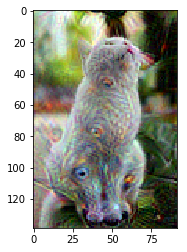

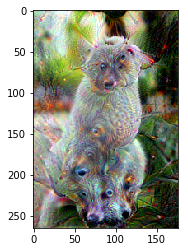

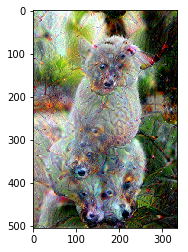

In [ ]:
#Step 3 - Pick a layer to enhance our image
layer = 'mixed4c_5x5_bottleneck_pre_relu'
channel = 20

#open image
img0 = PIL.Image.open('data/1.jpg')
img0 = np.float32(img0)
#Step 4 - Apply gradient ascent to that layer
print("###############LAYER")
render_deepdream(tf.square(T(layer)[:,:,:,channel]), img0,iter_n=50,step=1.6, octave_scale=)
print("###############################")
